In [1]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
# from sklearn.manifold import TSNE
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from random import randint
import seaborn as sns; sns.set_style("white")
import umap as umap

# import plotnine as gg
# from cytominer_eval import evaluate

os.getcwd()

2023-09-01 14:49:11.848776: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'/scratch2-shared/david/colopaint3D/notebooks'

In [2]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./output/2_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/1_FeaturesImages'


In [3]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    return ax.add_patch(ellipse)


In [4]:
read_data = pd.read_parquet(f'{FeatureDir}/spheroidSingleCell.parquet')
cbar = pd.DataFrame()
read_data.reset_index(inplace=True, drop = True)
training_data = read_data.copy()
# training_data = training_data.loc[:,~training_data.columns.str.contains('AreaShape_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Correlation_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Granularity_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Intensity_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('RadialDistribution_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Neighbors_', case=False)]
loc_data = training_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y']]
training_data = training_data.loc[:,~training_data.columns.str.contains('Location', case=True)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('ObjectNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('ImageNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Parent', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Children', case=True)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Neighbors_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_ObjectNumber', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Object_Number', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Y', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_X', case=True)]
# zplane = training_data['Metadata_Plane'].pop()
### Old Standardization
# df_norm = training_data.select_dtypes(include=np.number)
# df_norm = df_norm.loc[:,~df_norm.columns.str.contains('Metadata_', case=True)]
# std_values = df_norm.std(skipna=True)
# std_values[std_values == 0] = 1
# df_norm = ((df_norm - df_norm.mean(skipna=True)) / std_values)
# training_data[df_norm.columns] = df_norm

##### Correlation contains some kind of well information
# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]

### Old Cmpd MEta data and Onehot
# target = pd.DataFrame()
# metaEx = pd.read_csv('/home/jovyan/scratch2-shared/david/colopaint3D/notebooks/settings/pilot12-v2-Adjusted_5-metadata.csv', sep=',')
# target['Metadata_Cmpd'] = training_data['Metadata_Well'].apply(lambda x: metaEx.loc[metaEx['well_id'] == x, 'Metadata_Cmpd'].values[0])
# onehot_val = list(range(len(target['Metadata_Cmpd'].unique())))
# onehot_dict = dict(zip(target['Metadata_Cmpd'].unique(), onehot_val))
# target['onehot'] = target['Metadata_Cmpd'].apply(lambda x: onehot_dict.get(x, -1))
# training_data['Metadata_Cmpd'] = target['Metadata_Cmpd']
# training_data['onehot'] = target['onehot']

### New Onehot
target = pd.DataFrame()
onehot_val = list(range(len(training_data['Metadata_Cmpd'].unique())))
onehot_dict = dict(zip(training_data['Metadata_Cmpd'].unique(), onehot_val))
target['onehot'] = training_data['Metadata_Cmpd'].apply(lambda x: onehot_dict.get(x, -1))
training_data['onehot'] = target['onehot']

training_data = training_data.copy()



In [5]:
training_data.head()

Metadata_Barcode Metadata_Well  Metadata_Site Metadata_Cmpd   
0  pilot12-HCT116-day2           B02              2          etop  \
1  pilot12-HCT116-day2           B02              3          etop   
2  pilot12-HCT116-day2           B02              4          etop   
3  pilot12-HCT116-day2           B02              5          etop   
4  pilot12-HCT116-day2           B02              6          etop   

   Nuclei_AreaShape_Area  Nuclei_AreaShape_BoundingBoxArea   
0              -0.644654                         -0.434259  \
1              -0.221167                         -0.218909   
2               3.010566                          3.204267   
3               3.049063                          3.204267   
4              -1.443985                         -1.444889   

   Nuclei_AreaShape_Compactness  Nuclei_AreaShape_ConvexArea   
0                      1.329915                    -0.563561  \
1                     -0.290799                    -0.223724   
2                      1.479139                     3.083463   
3                      0.328553                     3.083463   
4                     -1.088569                    -1.451196   

   Nuclei_AreaShape_Eccentricity  Nuclei_AreaShape_EquivalentDiameter  ...   
0                       1.033898                            -0.573875  ...  \
1                      -0.141337                            -0.094363  ...   
2                       0.333715                             2.463881  ...   
3                      -0.689966                             2.488149  ...   
4                      -0.353224                            -1.758093  ...   

   Cells_RadialDistribution_ZernikePhase_SYTO_8_2   
0                                       -0.741245  \
1                                        1.052640   
2                                        1.555994   
3                                       -1.284240   
4                                       -1.161508   

   Cells_RadialDistribution_ZernikePhase_SYTO_8_4   
0                                       -0.678205  \
1                                       -1.279959   
2                                       -0.448259   
3                                        0.297758   
4                                        1.386236   

   Cells_RadialDistribution_ZernikePhase_SYTO_8_6   
0                                       -1.390552  \
1                                       -0.009796   
2                                       -1.674654   
3                                       -0.744100   
4                                       -1.651701   

   Cells_RadialDistribution_ZernikePhase_SYTO_8_8   
0                                       -0.570950  \
1                                        1.600653   
2                                        0.217714   
3                                        1.578506   
4                                       -0.065814   

   Cells_RadialDistribution_ZernikePhase_SYTO_9_1   
0                                        1.714480  \
1                                        1.407615   
2                                        0.843844   
3                                       -1.334575   
4                                       -1.228152   

   Cells_RadialDistribution_ZernikePhase_SYTO_9_3   
0                                       -0.899925  \
1                                       -1.435143   
2                                       -0.579900   
3                                       -0.745815   
4                                        1.244492   

   Cells_RadialDistribution_ZernikePhase_SYTO_9_5   
0                                       -0.696151  \
1                                       -0.376002   
2                                        0.534963   
3                                       -0.139993   
4                                       -1.430331   

   Cells_RadialDistribution_ZernikePhase_SYTO_9_7   
0                                       -0.976346  \
1                        

In [6]:
toNpy = training_data.loc[:,~training_data.columns.str.contains('Metadata_|onehot')]
toNpy.reset_index(inplace=True, drop=True)
toNpy = toNpy.copy()
dataNpy = toNpy.to_numpy()
colnames = toNpy.columns

In [7]:
np.isnan(dataNpy).any()


False

In [8]:
np.isinf(dataNpy).any()

False

In [9]:
dataPCA = pd.DataFrame()
dataPCA['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
dataPCA['onehot'] = training_data['onehot']

dataUMAP = pd.DataFrame()
dataUMAP['Metadata_Cmpd'] = training_data['Metadata_Cmpd']
dataUMAP['onehot'] = training_data['onehot']

In [10]:
# perplex = 20
pca_model = PCA(n_components=  2)
pca_model = pca_model.fit(dataNpy)
pcaOut = pca_model.transform(dataNpy)
dataPCA['pc1'] = pcaOut[:,0]
dataPCA['pc2'] = pcaOut[:,1]
dataPCA = dataPCA.copy()

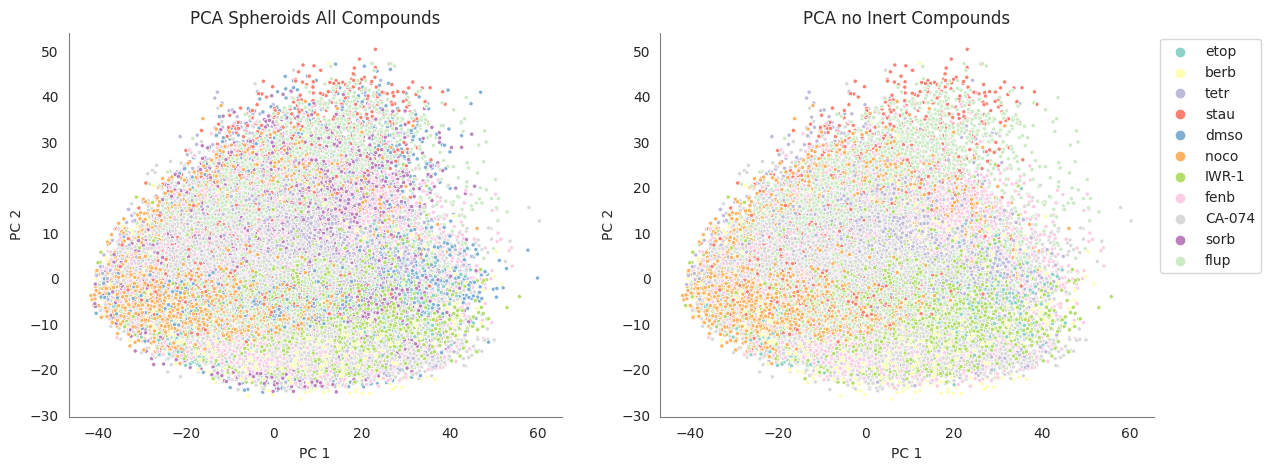

In [11]:
# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataPCA['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataPCA).set(title=f'PCA Spheroids All Compounds'
            )


noInert = dataPCA[~(dataPCA['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax = fig.add_subplot(122)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'PCA no Inert Compounds'
            )
ax.set_facecolor('w')
# ax.get_legend().remove()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/pca.png')
plt.show()
plt.close()
del noInert

In [12]:
min_dist=0.2
spread= 5
n_epochs=None
metric='cosine'

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


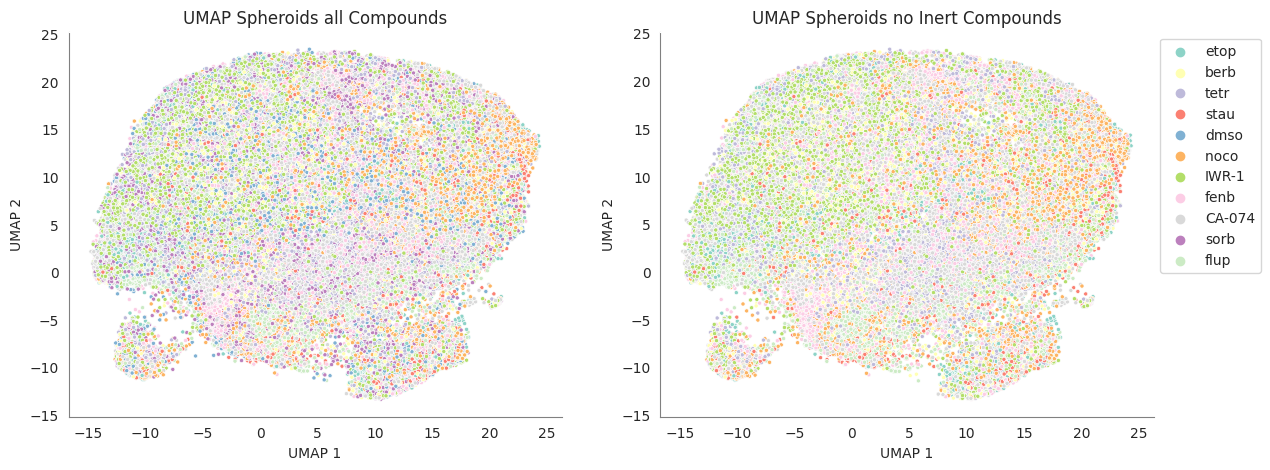

In [13]:
nn = 25
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()

ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# ax.get_legend().remove() 
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/umap{nn}nn.png')
plt.show()
plt.close()

In [14]:
# xlimPCA = [training_data['pc1'].min() - 0.2*abs(training_data['pc1'].min()), training_data['pc1'].max() + 0.2*abs(training_data['pc1'].max())]
# ylimPCA = [training_data['pc2'].min() - 0.2*abs(training_data['pc2'].min()), training_data['pc2'].max() + 0.2*abs(training_data['pc2'].max())]
# xlimUMAP = [training_data['umap1'].min() - 2, training_data['umap1'].max() + 0.2*abs(training_data['umap1'].max())]
# ylimUMAP = [training_data['umap2'].min() - 2, training_data['umap2'].max() + 0.2*abs(training_data['umap2'].max())]

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


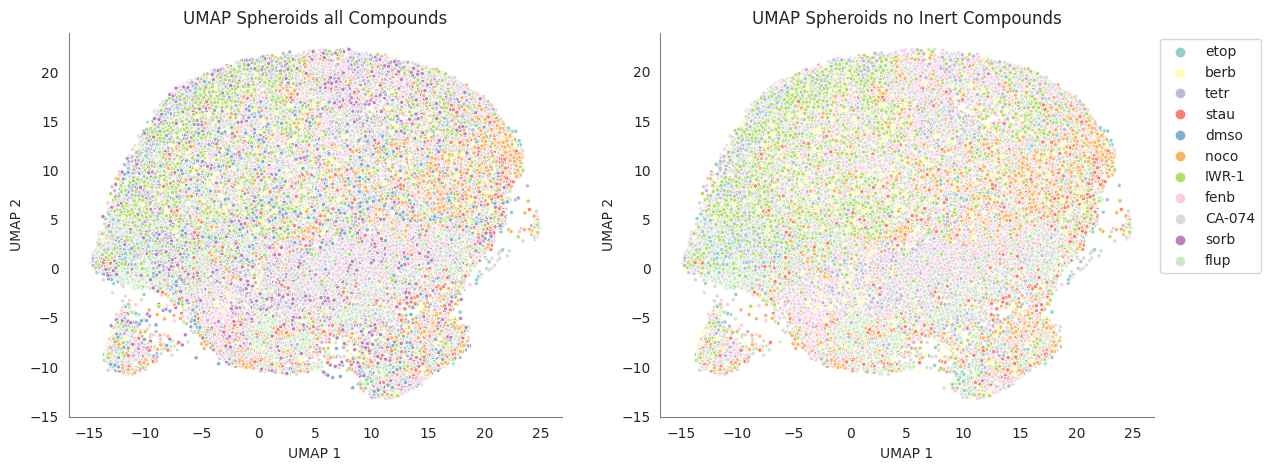

In [15]:
nn = 50
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/umap{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


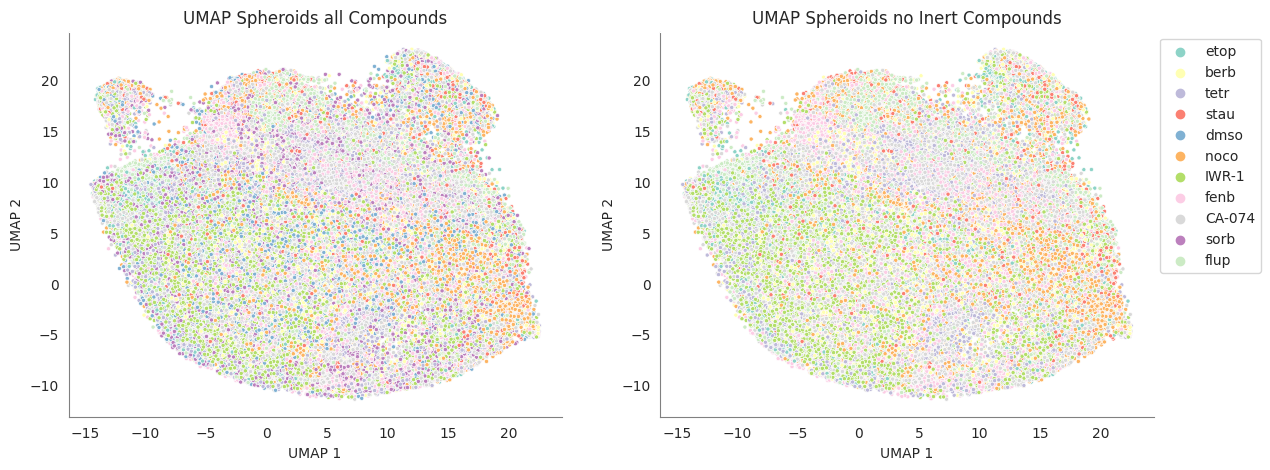

In [16]:
nn = 100
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/umap{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


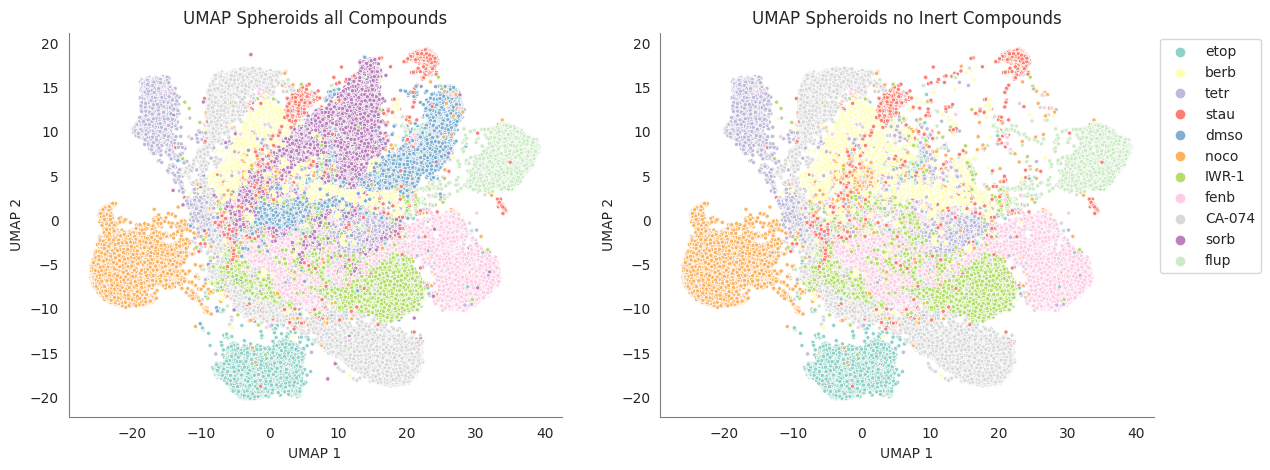

In [17]:
nn = 25
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy, y=dataUMAP['onehot'])
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )
noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/umapSupervised{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


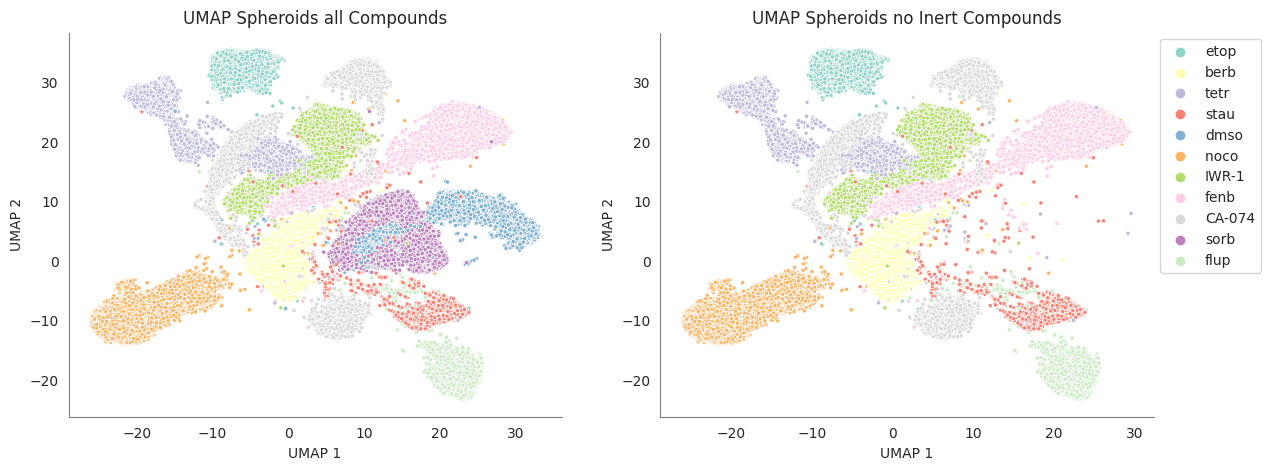

In [18]:
nn = 50
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy, y=dataUMAP['onehot'])
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )
noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/umapSupervised{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


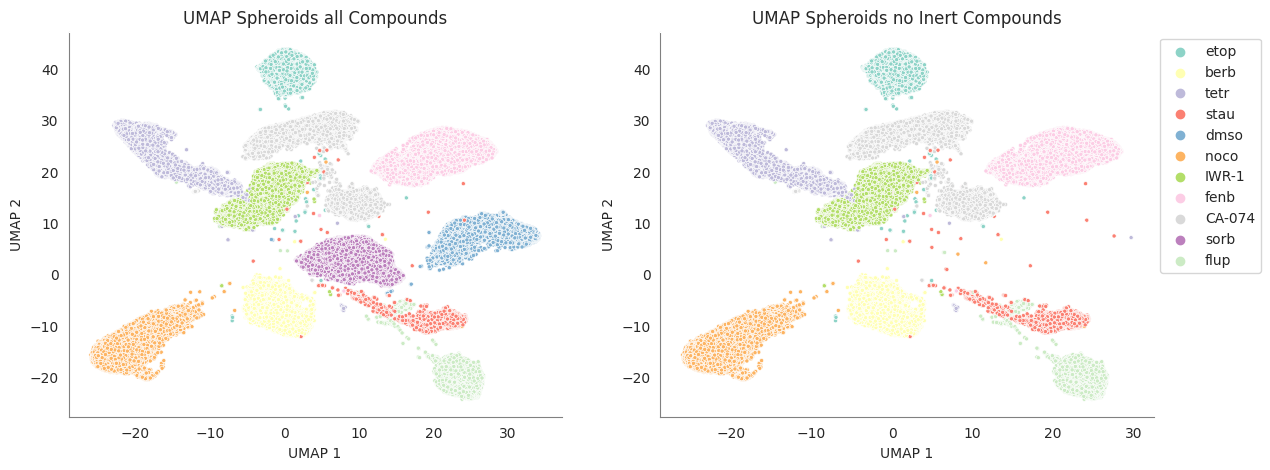

In [19]:
nn = 100
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy, y=dataUMAP['onehot'])
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )
noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/umapSupervised{nn}nn.png')
plt.show()
plt.close()

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


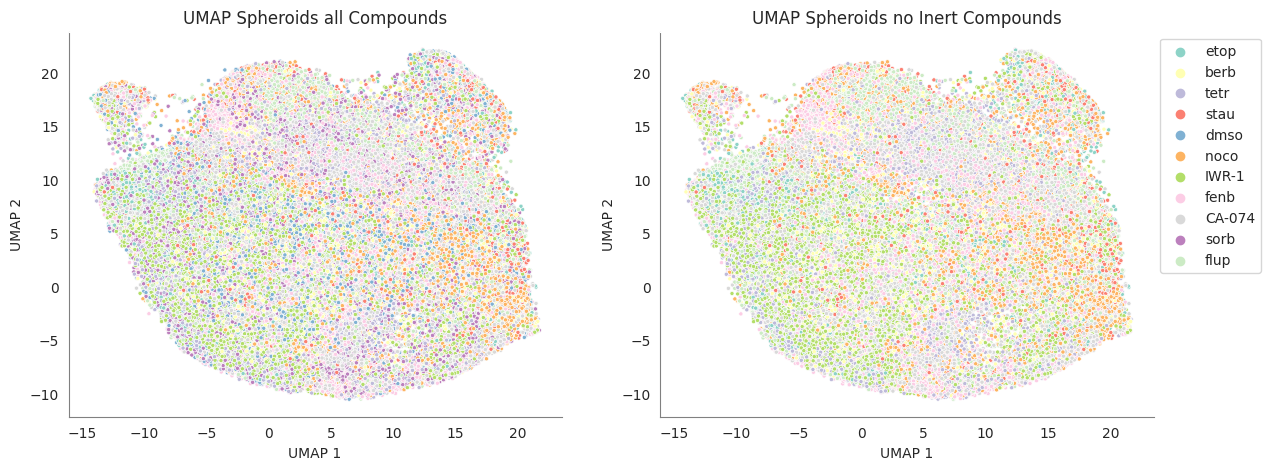

In [20]:
nn = 250
umap_model = umap.UMAP(n_neighbors=nn
                       , min_dist=min_dist
                       , spread= spread
                       , n_epochs=n_epochs
                       , metric=metric
                       )
umapOut = umap_model.fit_transform(dataNpy)
dataUMAP['umap1'] = umapOut[:,0]
dataUMAP['umap2'] = umapOut[:,1]
dataUMAP = dataUMAP.copy()

# cmap = sns.color_palette("hls", n_colors=11)
cmap = sns.color_palette("Set3", n_colors=12)
cmap = cmap[:11]
hue = dataUMAP['Metadata_Cmpd']
# hue = training_data['cluster']

fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=dataUMAP).set(title=f'UMAP Spheroids all Compounds'
            )


noInert = dataUMAP[~(dataUMAP['Metadata_Cmpd'] == 'dmso')]
noInert = noInert[~(noInert['Metadata_Cmpd'] == 'sorb')]
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    marker='.',
                    data=noInert).set(title=f'UMAP Spheroids no Inert Compounds'
            )
ax.set_facecolor('w')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f'{OutputDir}/umap{nn}nn.png')
plt.show()
plt.close()